In [17]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from operator import add
from tqdm import notebook
from time import time
import PQS_solver as PQS

The simulation has 3 different steps: 1. simulate the desiered signal to try to detect 2. use a ME simulation to gennerate a detection record 3. use desiered technique to estimate the simulated signal

## Global perameters

In [18]:
N_states = 5 # number of different singnal states
t_gamma = 10 # time of the simulation
gamma = 2 # characteristic decay rate
t = t_gamma / gamma # time of the simulation
dt = 0.5 # time step of the simulation
N_t = int(t / dt + 1) # number of time steps
times = np.linspace(0, t, N_t, endpoint=True) # time steps
seed_signal = 24 # seed for random number generator for the signal
seed_simulation = 8 # seed for random number generator for the simulation
t_signal_leadin = 1 # time for the stocastic nature of the signal to not be at 0 as the begining of the simulation
gamma_decay = gamma # decay rate of qubit out of cavity
gamma_phi = gamma # dephasing rate of qubit
Delta_n_min, Delta_n_max = -2 * gamma, 2 * gamma # range of the signal strengths
p = 0.02 * gamma # transition rate 







## Usefull functions

In [19]:
gamma_purcell = lambda Delta_n : 2 * g ** 2 * kappa / (kappa ** 2 + (Delta_r - Delta_n) ** 2)


# 1. Simulating the signal

The signal system i want to look at is a simple Hidden Markov Model, with 3 states, -1 $\gamma$, 0 and 1 $\gamma$ for the magnetic field affacting the spin. 

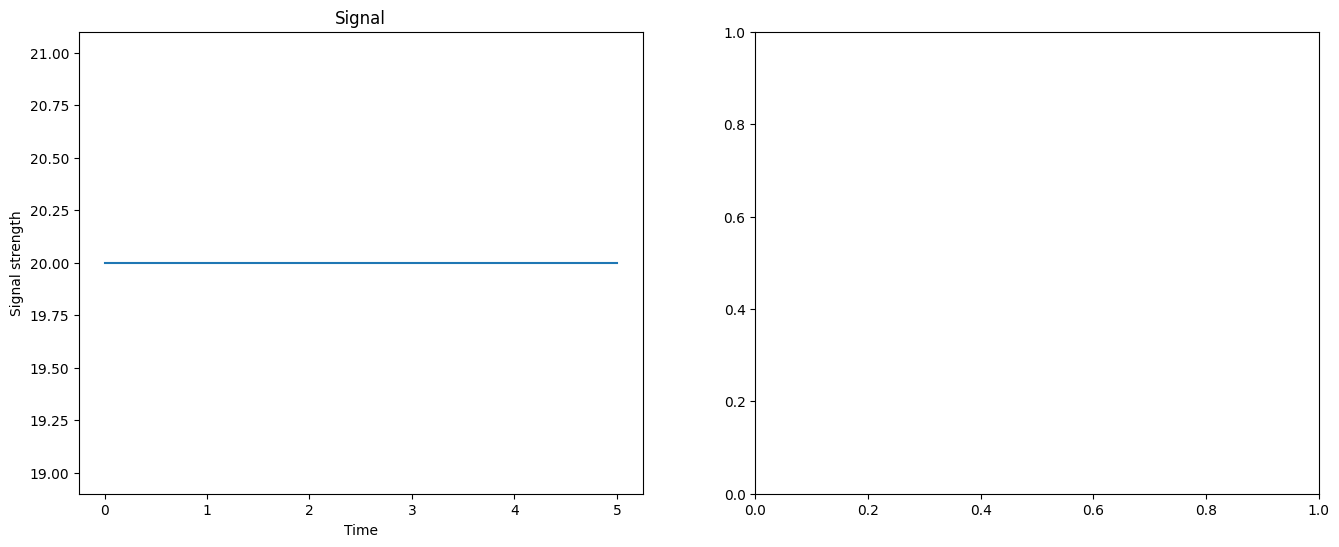

In [20]:
r_signal = np.random.default_rng(seed_signal) # random number generator for the signal
N_t_leadin = int(t_signal_leadin / dt) # number of time steps for the leadin of the signal



B = np.zeros(N_t_leadin + N_t, dtype=int) # signal strength
B_state = np.zeros(N_t_leadin + N_t, dtype=int) # state of the HMM

B_field_strength = 5

B_signal_stegths = (np.arange(N_states)) * B_field_strength # posible signal strengths

#B_signal_stegths = np.zeros(N_states)



st = 0.05 # to regulate the transtion rate between HMM states

def gennerate_r_next_neighbour_jump(N, st):
    r = np.eye(N, k=0) * (1 - 2 * st)
    r += np.eye(N, k=1) * st
    r += np.eye(N, k=-1) * st
    r[0, 0] = 1 - st
    r[-1, -1] = 1 - st
    return r

r_HMM = gennerate_r_next_neighbour_jump(N_states, st)


#col = plt.imshow(r_HMM, vmin=0, vmax=1)

#plt.colorbar(col)
#plt.show()

#r_HMM = np.array([[1 - 0.2 * st, 0.2 * st],
#                  [0.2 * st, 1 - 0.2 * st]]) # transition matrix of the HMM

#r_HMM = np.array([[1, 0],
#                  [0, 1]]) # transition matrix of the HMM





B_state[0] = int(N_states / 2)  # initial state of the HMM
B[0] = B_signal_stegths[B_state[0]] # initial signal strength





r_HMM_sim = np.zeros((N_states, N_states))

for i in range(N_states):
    for j in range(N_states):
        if i != j:
            r_HMM_sim[i, j] = r_HMM[i, j] * dt

for i in range(N_states):
    r_HMM_sim[i, i] = 1 - np.sum(r_HMM_sim[i, :])




# generate the signal
for i in range(1, N_t_leadin + N_t):
    q = r_signal.random()
    prob_sum = 0
    nr = 0
    while prob_sum < q:
        prob_sum += r_HMM_sim[B_state[i - 1], nr]
        nr += 1
    B[i] = B_signal_stegths[nr - 1]
    B_state[i] = nr - 1

    



B_new = B[N_t_leadin:] # remove the leadin of the signal
B_state_new = B_state[N_t_leadin:] # remove the leadin of the signal
Delta_n_posible = B_signal_stegths * gamma # possible signal strengths

#dW = dW[N_t_leadin:] # remove the leadin of the Wiener process
Delta_n = B_new * gamma # signal, rounded to the nearest integer as the ME simulationonly works for a descrete set of signal strengths

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

t_plot = np.linspace(0, t, N_t)

ax[0].plot(t_plot, Delta_n)
ax[0].set_title('Signal')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Signal strength')

#ax[1].set_title('Wiener process')
#ax[1].plot(t_plot, dW)

plt.show()



# 2. Simulate detection record

In [21]:
kappa = 10 * gamma # amplitude decay rate of cavity field due to transmission of the output field
kappa_1 = kappa # amplitude decay rate of cavity field due to loss
Delta_r = 0 # cavity detuning
g = 5 * gamma # coupling strength
beta = np.sqrt(gamma) # amplitude of driving field
alpha = np.sqrt(2 * kappa) * beta / (kappa + 1j * Delta_r)
epsilon_n = g ** 2 * (Delta_r - Delta_n) / (kappa ** 2 + (Delta_r - Delta_n)** 2)

epsilon_n = epsilon_n.tolist()

epsilon_n_posible = g ** 2 * (Delta_r - Delta_n_posible) / (kappa ** 2 + (Delta_r - Delta_n_posible) ** 2) # possible epsilon strengths

sigma_z = qt.sigmaz() # Pauli-Z operator for qubit
sigma_p = qt.sigmap() # raising operator for qubit
sigma_m = qt.sigmam() # lowering operator for qubit


c_1 = qt.QobjEvo([sigma_m, lambda t : np.sqrt(gamma_purcell(Delta_n[int(t/dt)])).tolist()])
c_2 = np.sqrt(gamma_decay) * sigma_m # decay of qubit out of the cavity
c_3 = np.sqrt(gamma_phi / 2) * sigma_z # dephasing of qubit



c_out_part_1 = qt.QobjEvo([sigma_m, lambda t : 1j * g / (kappa + 1j * (Delta_r - Delta_n[int(t/dt)]))])

c_out = np.sqrt(2 * kappa_1) * (alpha - c_out_part_1) - beta




rho_0 = qt.basis(2, 0) * qt.basis(2, 0).dag() # density matrix of the qubit

H_1 = qt.QobjEvo([sigma_z, lambda t : Delta_n[int(t/dt)] / 2])

H_2 = qt.QobjEvo([sigma_p * sigma_m, lambda t : epsilon_n[int(t/dt)]])

H = H_1 + g * (alpha  * sigma_p + np.conjugate(alpha) * sigma_m) - H_2



To get a detection record, one will need to use the stocastic masterequation solver smesolve, and include the argument {"store_measurement": True}. The default measurment methode is homodyne detection, hetrodyne detection is also posible. c_ops is the lindbald colaps oporators, sc_ops is the stocastic colaps oporators, and e_ops is the oporator witch the expectation value will be saved

# 3. Estimate signal

As the system is subject to homodyne dectection, then the system evolves after a stocastic master equation 
$$\tilde{\rho}(t + dt) = \tilde{\rho}(t) +d\tilde{\rho}$$ 
where 
$ $d\tilde{\rho}=L\tilde{\rho}dt + \chi_\phi \tilde{\rho}dY_t $$
Where $dY_t$ is the detection record. To be able to accomidate the HMM, we will exted the hilbert space to include the HHM states so 
$$ \tilde{\rho} = \Sigma_n\tilde{\rho}_n \otimes \ket{n} \bra{n} $$, 
and 
$$ \chi_\phi = \sqrt{\nu}(\hat{c}_{out}e^{-i\phi}\rho - \rho \hat{c}^\dag _{out}e^{i\phi}) $$
with coresponding Lindblad oporators 
$$\hat{J}_{nn'}=\sqrt{r_{nn'}}\ket{n'}\bra{n}$$. 
The goal is to predict the HMM state n, and the probability of being in state n is 
$$P_n(t)=\textrm{Tr}[\rho_n(t)]$$
to normelize $\tilde{\rho}_n$ to get $\rho_n$ this is done by 
$$\rho_n = \frac{\tilde{\rho}_n}{\textrm{Tr}(\tilde{\rho})}$$
As the new Hilbert space is bigger, we need to redefine all of our oporators and the hamiltonian. for most oporators that dont depend on the state of the HMM this i suficent 
$$\hat{a}_{new}= a \otimes I_{N+1}$$
but of oporator witch are dependent on the HMM state, then inseted of the identity a diagonelized array of the diferent coeficents for the states will be used
The transition rate $r_{nn'}$ have to be given, and scice the state of the HMM only can change to the naigboring states, then $r_{nn'}$ is an matrix with non 0 on the 2 closest offdiagonals




Now that we have a detection record, it can be inserted on the stocastic dW place. The thing is that the output signal is $ Tr(c_{out} \rho c_{out}^\dag) + dw$.

In [22]:
"""
rho_0 = qt.basis(2, 0) * qt.basis(2, 0).dag() # density matrix of the qubit
rho_n = 1/N_states * qt.basis(N_states, 0) * qt.basis(N_states, 0).dag() # density matrix of HMM states
for i in range(1, N_states):
    rho_n += 1/N_states * qt.basis(N_states, i) * qt.basis(N_states, i).dag() # density matrix of HMM states
rho_HMM = qt.tensor(rho_0, rho_n) # density matrix of the qubit and HMM

I_n = qt.qeye(N_states) # identity operator for the HMM

sigma_z_HMM = qt.tensor(sigma_z, I_n) # Pauli-Z operator for qubit
sigma_p_HMM = qt.tensor(sigma_p, I_n) # raising operator for qubit
sigma_m_HMM = qt.tensor(sigma_m, I_n) # lowering operator for qubit


Delta_n_posible = B_signal_stegths * gamma # possible signal strengths

epsilon_n_posible = g ** 2 * (Delta_r - Delta_n_posible) / (kappa ** 2 + (Delta_r - Delta_n_posible) ** 2) # possible epsilon strengths

c_1_HMM = qt.tensor(1 / 2 * sigma_m, qt.qdiags(np.sqrt(gamma_purcell(Delta_n_posible))))
c_2_HMM = np.sqrt(gamma_decay) * sigma_m_HMM # decay of qubit out of the cavity
c_3_HMM = np.sqrt(gamma_phi / 2) * sigma_z_HMM # dephasing of qubit


c_out_part_1 = qt.tensor(qt.qdiags(1j * g / (kappa + 1j * (Delta_r - Delta_n_posible))), sigma_m)

c_out_HMM = np.sqrt(2 * kappa_1) * (alpha - c_out_part_1) - beta


H_1_HMM = qt.tensor(sigma_z, qt.qdiags(Delta_n_posible / 2))
sigma_p * sigma_m * epsilon_n[i]
H_2_HMM = qt.tensor(sigma_p * sigma_m, qt.qdiags(epsilon_n_posible))

H_HMM = H_1_HMM + g * (alpha  * sigma_p_HMM + np.conjugate(alpha) * sigma_m_HMM) - H_2_HMM


### jump oporators for the HMM states

r_HMM_jump = r_HMM_sim.copy()
r_HMM_jump = r_HMM_jump - np.eye(len(B_signal_stegths)) * np.diag(r_HMM_jump) # remove the diagonal elements
#r = p * np.eye(N+1, k=-1) + np.eye(N+1, k=1) # transition matrix of the HMM
J_HMM_list = []
    
for i in range(N_states):
    for j in range(N_states):
        if r_HMM_jump[i, j] != 0:
            J_HMM_list.append(qt.tensor(qt.qeye(2), np.sqrt(r_HMM_jump[i, j]) * qt.basis(N_states, j) * qt.basis(N_states, i).dag()))
    


B_state_oporator = qt.tensor(qt.qdiags(B_signal_stegths), qt.qeye(2))
"""


'\nrho_0 = qt.basis(2, 0) * qt.basis(2, 0).dag() # density matrix of the qubit\nrho_n = 1/N_states * qt.basis(N_states, 0) * qt.basis(N_states, 0).dag() # density matrix of HMM states\nfor i in range(1, N_states):\n    rho_n += 1/N_states * qt.basis(N_states, i) * qt.basis(N_states, i).dag() # density matrix of HMM states\nrho_HMM = qt.tensor(rho_0, rho_n) # density matrix of the qubit and HMM\n\nI_n = qt.qeye(N_states) # identity operator for the HMM\n\nsigma_z_HMM = qt.tensor(sigma_z, I_n) # Pauli-Z operator for qubit\nsigma_p_HMM = qt.tensor(sigma_p, I_n) # raising operator for qubit\nsigma_m_HMM = qt.tensor(sigma_m, I_n) # lowering operator for qubit\n\n\nDelta_n_posible = B_signal_stegths * gamma # possible signal strengths\n\nepsilon_n_posible = g ** 2 * (Delta_r - Delta_n_posible) / (kappa ** 2 + (Delta_r - Delta_n_posible) ** 2) # possible epsilon strengths\n\nc_1_HMM = qt.tensor(1 / 2 * sigma_m, qt.qdiags(np.sqrt(gamma_purcell(Delta_n_posible))))\nc_2_HMM = np.sqrt(gamma_decay

# My own solver

## Gennerating the detection record

  0%|          | 0/11 [00:00<?, ?it/s]

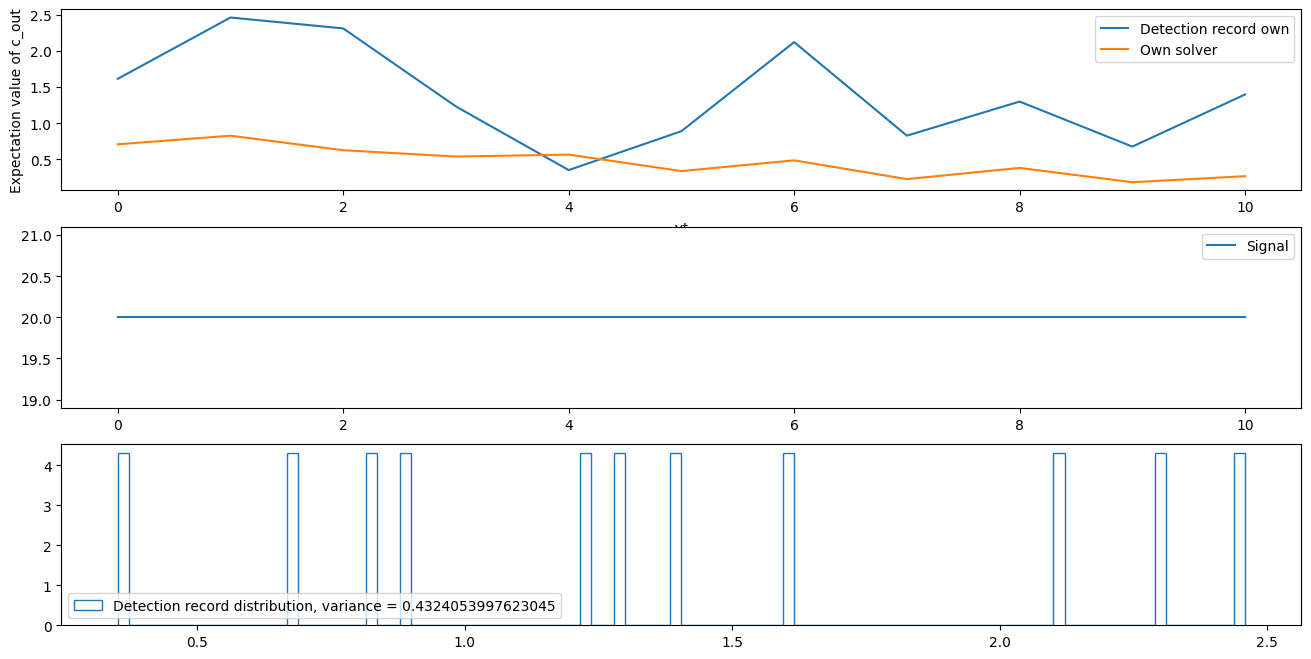

In [23]:
#N = 1

#noise_factor = 0.004
noise_factor = 1

c_1 = lambda i: sigma_m * np.sqrt(gamma_purcell(Delta_n[i]))
c_2 = lambda i: np.sqrt(gamma_decay) * sigma_m # decay of qubit out of the cavity
c_3 = lambda i: np.sqrt(gamma_phi / 2) * sigma_z # dephasing of qubit
c_out = lambda i: np.sqrt(2 * kappa_1) * (alpha - sigma_m * 1j * g / (kappa + 1j * (Delta_r - Delta_n[i]))) - beta
c_out_dag = lambda i: np.sqrt(2 * kappa_1) * (alpha + sigma_p * 1j * g / (kappa - 1j * (Delta_r - Delta_n[i]))) - beta





c_ops_1 = [[c_1(i), c_2(i), c_3(i)] for i in range(N_t)] 
rho_0 = qt.basis(2, 0) * qt.basis(2, 0).dag()

sc_ops = [[c_out(i)] for i in range(N_t)]

e_ops = [[c_out(i) + c_out_dag(i)] for i in range(N_t)]




#H_1 = qt.QobjEvo([sigma_z, lambda t : Delta_n[int(t/dt)] / 2])

#H_2 = qt.QobjEvo([sigma_p * sigma_m, lambda t : epsilon_n[int(t/dt)]])

H_pqs = [sigma_z * Delta_n[i] / 2  + g * (alpha  * sigma_p + np.conjugate(alpha) * sigma_m) - sigma_p * sigma_m * epsilon_n[i] for i in range(N_t)]
#H_pqs_2 = [sigma_p * sigma_m * epsilon_n[i] for i in range(N_t)]


#H_pqs_1 = sigma_z * Delta_n / 2
#H_pqs_2 = sigma_p * sigma_m * epsilon_n
#H_pqs = H_pqs_1 + g * (alpha  * sigma_p + np.conjugate(alpha) * sigma_m) - H_pqs_2

#e_ops_list = [list(map(add, c_out, c_out_dag))]

PQSs = PQS.Experiment_simulation(H_pqs, rho_0, times, c_ops=c_ops_1, sc_ops=sc_ops, e_ops=e_ops, timedependent_H=True) # not very elegant that one need to write the 1 at N_states
PQSs.solve_homodyne(noise_factor=noise_factor, methode='Kraus')

dw_gennerated = PQSs.dw





fig, ax = plt.subplots(3, 1, figsize=(16, 8))

#print(PQS.expectation[0, 0])

times_gamma = times * gamma 


ax[0].plot(times_gamma, PQSs.detection_record[:,0], label='Detection record own')
ax[0].plot(times_gamma, PQSs.expectation[:,0] * dt, label='Own solver')
#ax[0].plot(times, stocastic_solution.expect[0], label='Qutip')
#ax[0].plot(times[1:], np.array(stocastic_solution.measurement).mean(axis=0)[0, :].real, label='Detection record qutip')
ax[0].set_xlabel('$\gamma t$')
ax[0].set_ylabel('Expectation value of c_out')

ax[1].plot(times_gamma, Delta_n, label='Signal')

ax[2].hist(PQSs.detection_record[:,0], bins=100, density=True, label=f'Detection record distribution, variance = {np.var(PQSs.detection_record[:, 0])}', histtype='step')

ax[0].legend()
ax[1].legend()
ax[2].legend()



There defenetly seams to be a factor 2 hiding somewhere, but seams not that importent for the conceptual take away from the simulation. The noise is also significantly smaller, but i used the weiner increment from the paper with mean 0 and variance $dt$

## Estimating the magnetic field 

In [24]:
Y = PQSs.detection_record
#Y = PQSs.dw



c_1_HMM = lambda i: sigma_m * np.sqrt(gamma_purcell(Delta_n_posible[i]))
c_2_HMM = lambda i: np.sqrt(gamma_decay) * sigma_m # decay of qubit out of the cavity
c_3_HMM = lambda i: np.sqrt(gamma_phi / 2) * sigma_z # dephasing of qubit
c_out_HMM = lambda i: np.sqrt(2 * kappa_1) * (alpha - sigma_m * 1j * g / (kappa + 1j * (Delta_r - Delta_n_posible[i]))) - beta
c_out_dag_HMM = lambda i: np.sqrt(2 * kappa_1) * (alpha + sigma_p * 1j * g / (kappa - 1j * (Delta_r - Delta_n_posible[i]))) - beta


rho_0 = qt.basis(2, 0) * qt.basis(2, 0).dag()  # density matrix of the qubit

#rho_HMM = [rho_0 / N_states for i in range(N_states)] # density matrix of the qubit and HMM


rho_HMM = [rho_0 / N_states for i in range(N_states)] # density matrix of the qubit and HMM





H_1 = lambda i: sigma_z * Delta_n_posible[i] / 2  + g * (alpha  * sigma_p + np.conjugate(alpha) * sigma_m) - sigma_p * sigma_m * epsilon_n_posible[i]

H_HMM = [H_1(i) for i in range(N_states)]




### jump oporators for the HMM states

#r_HMM_jump = r_HMM_sim.copy()
#r_HMM_jump = r_HMM_jump - np.eye(len(B_signal_stegths)) * np.diag(r_HMM_jump) # remove the diagonal elements
#r = p * np.eye(N+1, k=-1) + np.eye(N+1, k=1) # transition matrix of the HMM


#J_HMM_list = []

J_index = []

for i in range(N_states):
    for j in range(N_states):
        if i != j:#if r_HMM_jump[i, j] != 0:
            if r_HMM[i, j] != 0:
                J_index.append([i, j])
                #J_HMM_list.append(qt.tensor(qt.qeye(2), np.sqrt(r_HMM_jump[i, j]) * qt.basis(N_states, j) * qt.basis(N_states, i).dag()))
            #J_HMM_list.append(qt.tensor(np.sqrt(r_HMM_sim[i, j]) * qt.basis(N_states, j) * qt.basis(N_states, i).dag(), qt.qeye(2)))
    
#print(J_HMM_list)
J_index = np.array(J_index)





c_ops_HMM = [[c_1_HMM(i), c_2_HMM(i), c_3_HMM(i)] for i in range(N_states)]#, *J_HMM_list]

sc_ops_HMM = [[c_out_HMM(i)] for i in range(N_states)]
#c_out_part_1 = qt.tensor(sigma_m,  qt.qdiags(1j * g / (kappa + 1j * (Delta_r - Delta_n_posible))))



e_ops_HMM = [[c_out_HMM(i) + c_out_dag_HMM(i)] for i in range(N_states)] # n_op


#Y -= np.mean(Y)


PQS_estimater = PQS.Experiment_estimation(H_HMM, rho_HMM, times, c_ops_HMM, sc_ops_HMM, N_states, r_HMM, J_index, e_ops=e_ops_HMM, timedependent_H=False)
#PQS_estimater.import_expectation_values(PQSs.expectation)
PQS_estimater.solve_PQS_multi(Y, methode='Kraus')



#dv_estimated = PQS_estimater.dv
#print(PQS_estimater.rho[10], (PQS_estimater.rho[10] * n_op).tr())





  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Exception in thread Thread-11 (solve_homodyne_E):
Traceback (most recent call last):
  File "/home/sk0rt3/anaconda3/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/home/sk0rt3/anaconda3/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sk0rt3/Documents/Masters/2024-2025/Masters_thesis/Code/Master_thesis/PQS_solver.py", line 563, in solve_homodyne_E
    d_E.append(self.next_step_homodyne_E(dv[index], self.H[i], self.E[index][i], self.E[index], self.c_ops[i], self.sc_ops[i], methode=methode, order=order))
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sk0rt3/Documents/Masters/2024-2025/Masters_thesis/Code/Master_thesis/PQS_solver.py", line 606, in next_step_homodyne_E
    return d_E
           ^^^
UnboundLocalError: cannot access local variable 'd_E' where it is not associa

  0%|          | 0/11 [00:00<?, ?it/s]

IndexError: list index out of range

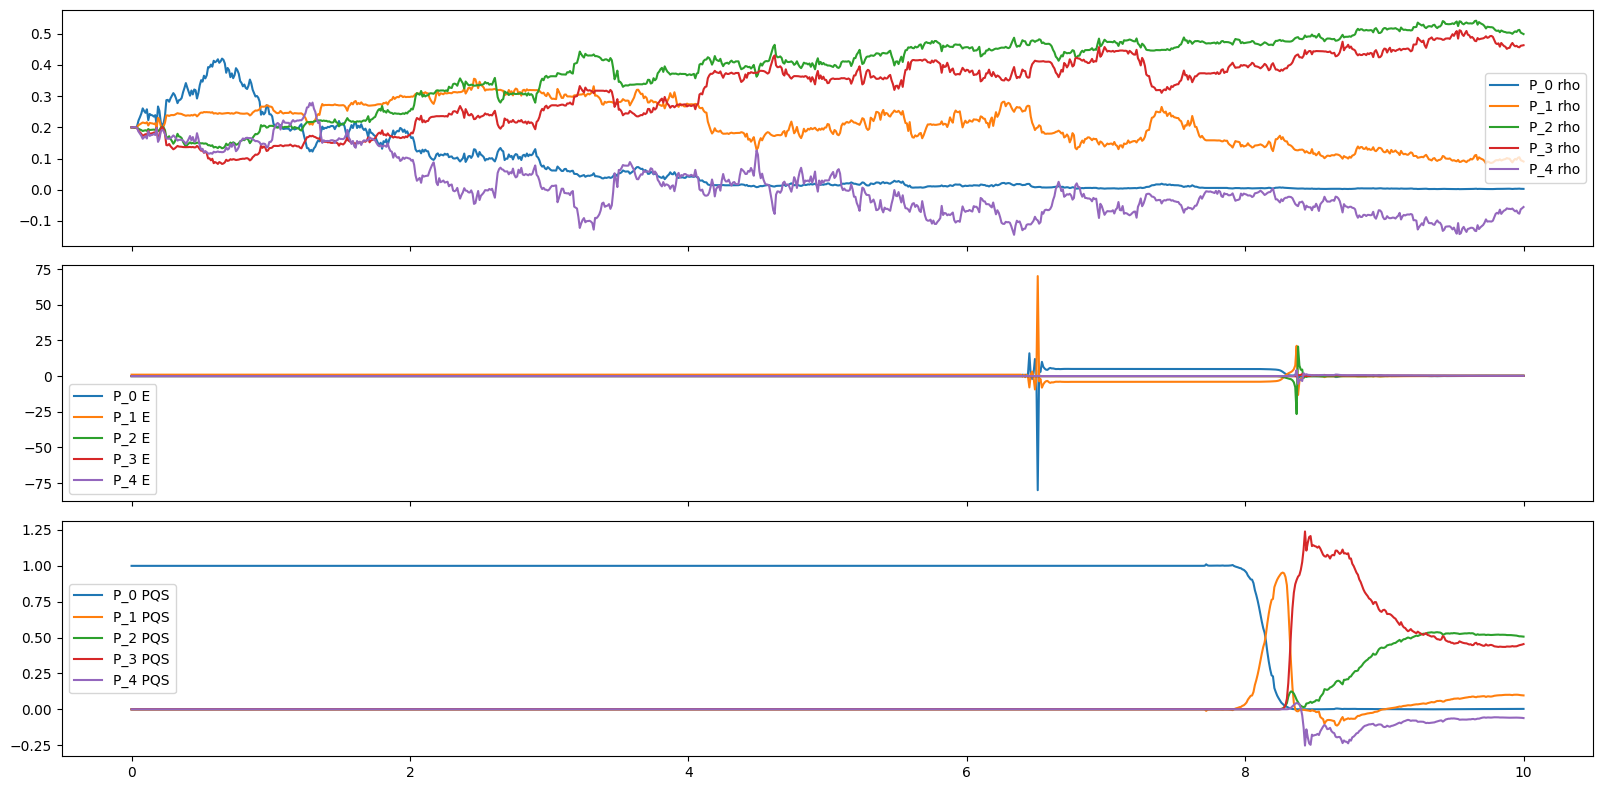

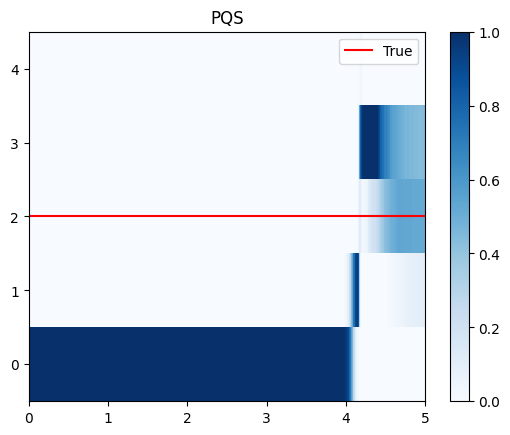

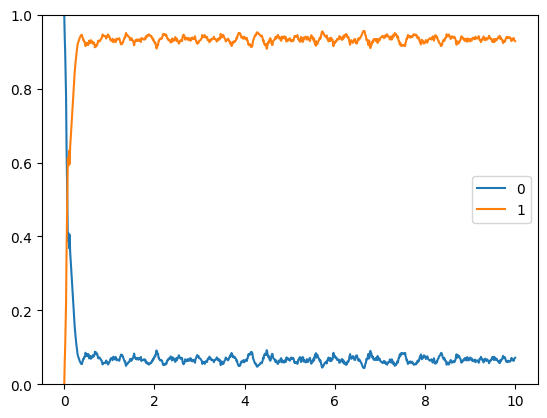

In [ ]:
def plot_estimate(estimate_signal, True_signal, N_states):
    #fig, ax = plt.subplots(figsize=(16, 8))

    c = plt.imshow(estimate_signal.T, aspect='auto', extent=[0, 
                    times_gamma[-1], -1/2, N_states -1/2], origin='lower', 
                    cmap='Blues', vmin=0, vmax=1, interpolation='none')
    plt.plot(times_gamma, True_signal, label='True', color='red')
    #ax.set_xlabel('$\gamma t$')
    plt.legend()
    plt.colorbar(c)
    plt.show()



#print(np.shape(PQS_estimater.P_n_PQS))


fig, ax = plt.subplots(3, 1, figsize=(16, 8), sharex=True)

P_most_likely = np.argmax(PQS_estimater.P_n_PQS, axis=1)

#PQS_estimater.viterbi(r_HMM_jump, np.ones(N_states)/ N_states, PQS_estimater.P_n_PQS)
#viterbi_path = PQS_estimater.viterbi_states

for i in range(N_states):
    ax[0].plot(times_gamma, PQS_estimater.P_n_rho[:, i], label=f'P_{i} rho')
    ax[1].plot(times_gamma, PQS_estimater.P_n_E[:, i], label=f'P_{i} E')
    ax[2].plot(times_gamma, PQS_estimater.P_n_PQS[:, i], label=f'P_{i} PQS')

#ax[2].plot(times_gamma, viterbi_path, label='Viterbi')




#ax[0].set_ylabel('Expectation value of c_out')

#ax[2].plot(times_gamma, Delta_n, label='Signal')

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.tight_layout()
plt.show()

PQS.plot_estimate_hist(times, PQS_estimater.P_n_PQS.real, B_state_new, N_states, title='PQS')



rho_list = np.zeros((N_t, 2), dtype=complex)
for i in range(N_t):
    rho_list[i] = PQSs.rho[i].diag()

for i in range(2):
    plt.plot(times_gamma, rho_list[:,i], label=f'{i}')
plt.legend()
plt.ylim(0, 1)
plt.show()


In [ ]:
print(beta)

1.4142135623730951


In [ ]:
print(np.mean(PQS_estimater.dv_rho[0]), np.mean(PQS_estimater.dv_E[0]))
print(np.mean(PQS_estimater.dv_rho[0]) - np.mean(PQS_estimater.dv_E[0]))

-0.05026917413303933 -0.07185216304285924
0.02158298890981991


In [ ]:
from operator import add

a = [1, 2, 3, 4, 5]
b = [1, 2, 3, 4, 5]
c = list(map(add, a, b) )

print(c)



[2, 4, 6, 8, 10]


In [ ]:
import threading

class Testclass:
    def __init__(self):
        self.c = 0
        self.a = 0
        self.b = 0

    def func_1(self, a):
        if threading.current_thread().name == 't2':
            print('t1 is running func_1')
        self.a = a
        self.func_3(self.c)
        print(threading.current_thread().name)

    def func_3(self, c):
        self.d = self.a + c

        
        
        

    def func_2(self, a):
        self.b = 2 * a + self.c

    def run_funcs(self):
        if __name__ == '__main__':

            t1 = threading.Thread(target=self.func_1, args=(1,), name='t1')
            t2 = threading.Thread(target=self.func_2, args=(2,), name='t2')

            t1.start()
            t2.start()

            t1.join()
            t2.join()
            #mydata = threading.local()
            print(self.a, self.b)
            
            print(threading.current_thread().name)
            
            


            print('done')

test = Testclass()
test.run_funcs()


t1
1 4
MainThread
done
